Aim: Verify if call on imports is an accurate measure

Next Steps:
* intgrate kpler inventories into balance?..

In [ ]:
from tshistory.api import timeseries
from seasonal_plot import seasonal_plot as snp
from seasonal_plot import generate_seasonal_frame as gns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import pandas as pd
from datetime import datetime
tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api')

In [ ]:
def convert_seasonal(series):
    df = series.to_frame()
    df = df.resample('MS').mean()
    df['year'] = df.index.year
    df['month'] = df.index.month
    return df.pivot(columns='year', index='month')

In [ ]:
kpler_inv = "crude.kpler.oecd_europe.ending_stocks.mb.daily"
iea_inv = "crude.iea.oecd_europe.ending_stocks.kb.monthly"
iea_inv = "crude.iea.oecd_europe.commercial_stocks.kb.monthly"
cover = "crude.petroineos.oecd_europe.days_cover.monthly.forecast"
total_cap = "oil.petroineos.oecd_europe.cdu.capacity.kbd.daily"
av_cap = "oil.petroineos.oecd_europe.cdu.available_capacity.kbd.monthly"

inventories = tsa.get(iea_inv)
total_capacity = tsa.get(total_cap).resample('MS').mean()
av_capacity = tsa.get(av_cap)
days_cover = tsa.get(cover).loc[:'2022']
inv_delta = inventories.diff()
cover_total_cap = inventories.divide(total_capacity).dropna()
cover_av_cap =  inventories.divide(av_capacity).dropna()

print(f'{len(inventories)}, {len(total_capacity)}, {len(av_capacity)}')
print(f' totalcap {len(cover_total_cap)}, avcap {len(cover_av_cap)}')

## spreads vs NWE imports

* exports vs freight / structure
* exports vs structure has a polynomial relationship

In [25]:
imports = tsa.get('crude.kpler.oecd_europe.imports.kbd.monthly')
kpler_exports = tsa.get('crude.kpler.oecd_europe.exports.kbd.daily')
imports_iea = tsa.get('crude.iea.oecd_europe.imports.kbd.monthly')
exports_iea = tsa.get('crude.iea.oecd_europe.exports.kbd.monthly')
spread = tsa.get('price.platts.ice_brent_swap_spread.m01.usd_bbl.daily')
spread_m = tsa.get('price.platts.ice_brent_swap_spread.m01.usd_bbl.daily').resample('MS').mean()
df = pd.merge(spread_m,exports_iea, left_index=True, right_index=True)
df_weekly = pd.merge(spread.resample('W').mean(),kpler_exports.resample('W').mean(), left_index=True, right_index=True)

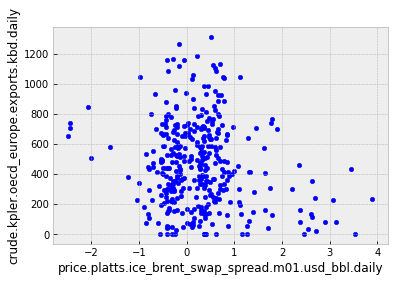

In [32]:
df_weekly.loc['2016':].plot.scatter(x=df_weekly.columns[0], y=df_weekly.columns[1])

In [171]:
df.head()

price.platts.ice_brent_swap_spread.m01.usd_bbl.daily  \
2014-01-01                                           0.407273      
2014-02-01                                           0.351500      
2014-03-01                                           0.315238      
2014-04-01                                           0.378000      
2014-05-01                                           0.674500      

            crude.kpler.oecd_europe.imports.kbd.monthly  
2014-01-01                                  4709.759700  
2014-02-01                                  6144.235286  
2014-03-01                                  6005.781548  
2014-04-01                                  6538.637967  
2014-05-01                                  6942.357935

In [116]:
projected_inventory = tsa.get("crude.iea.oecd_europe.inventory_forward_curve.kb.monthly")

In [119]:
inv_delta = projected_inventory.diff()

### verifying call on imports

In [38]:
call = tsa.get("crude.petroineos.oecd_europe.call_on_imports.kbd.monthly")
actual_kpler = tsa.get("crude.kpler.oecd_europe.imports.kbd.monthly")
actual_iea_imports = tsa.get("crude.iea.oecd_europe.waterborne_imports.kbd.monthly")
druzbha = tsa.get("crude.petroineos.russia.oecd_europe.pipe_exports.kbd.monthly")
stock_change = tsa.get("crude.iea.oecd_europe.commercial_stocks.delta.kb.monthly")

print(f'kpler: {len(actual_kpler)}, IEA:{len(actual_iea_imports)},druzbha:{len(druzbha)}, call: {len(call)}, stck: {len(stock_change)}')

kpler: 109, IEA:154,druzbha:156, call: 143, stck: 213


In [39]:
predicted_stock_change = actual_iea_imports - call
predicted_stock_change.dropna(inplace=True)

In [43]:
pred_stock_change_kbbls = predicted_stock_change * predicted_stock_change.index.days_in_month

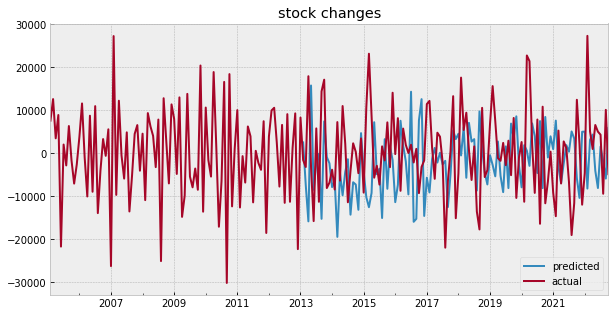

In [53]:
fig, ax = plt.subplots(1,figsize=(10,5))
pred_stock_change_kbbls.plot(ax=ax)
stock_change.plot(ax=ax)
ax.set_title(label='stock changes')
ax.legend(['predicted', 'actual'])

In [45]:
diff = pred_stock_change_kbbls - stock_change

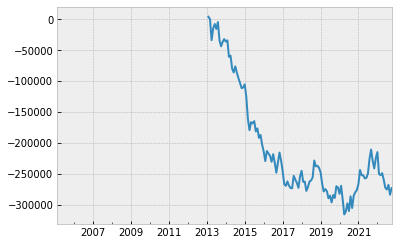

In [47]:
diff.cumsum().plot()

### Comparison of kpler inventories vs IEA inventories

In [ ]:
kpler_inv = tsa.get('crude.kpler.oecd_europe.ending_stocks.mb.daily').resample('MS').mean()*1000
iea_inv = tsa.get('crude.iea.oecd_europe.commercial_stocks.kb.monthly')
fig, ax = plt.subplots()
iea_inv.plot(ax=ax)
ax2 = ax.twinx()
kpler_inv.plot(ax=ax2, color='maroon')
ax.set_title(label='inventories')
ax.legend(['IEA', 'kpler'])

In [ ]:
inv = pd.merge(kpler_inv, iea_inv, left_index=True, right_index=True)
inv.plot.scatter(x='crude.kpler.oecd_europe.ending_stocks.mb.daily', y='crude.iea.oecd_europe.commercial_stocks.kb.monthly')

In [ ]:
inv.columns

In [ ]:
# modeling OLS with druzbha
x = inv['druzbha_short']
y = inv['crude.kpler.oecd_europe.imports.kbd.monthly']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()